# Machine Learning project a.y. 2021/2022

## Scikit-learn MLP model

## Importing libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.base import clone as clone_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier

## Evaluation metrics

We define the <b>MEE (Mean Euclidean Error)</b> function which is used to evaluate the mean euclidean distance between two points with x and y coordinates.
The function takes in input the true target and the predicted target and yields a floating point number which represents the performance. 

In [ ]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

We also define a random state (seed) to allow reproducibility on our experiments

In [ ]:
RS_NUMBER = 69

## MONK Dataset
### MONK1

In [ ]:
def load_monk(path_train, path_test):
    df_monk_train = pd.read_csv(path_train, sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
    df_monk_train.drop(labels='id', axis=1, inplace=True)

    df_monk_test = pd.read_csv(path_test, sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
    df_monk_test.drop(labels='id', axis=1, inplace=True)

    return df_monk_train, df_monk_test

### Loading MONK1 dataset

In [ ]:
df_monk1_train, df_monk1_test = load_monk('./data/MONK/monks-1.train', './data/MONK/monks-1.test')

In [ ]:
df_monk1_train.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [ ]:
def split_train_test(df_monk_train, df_monk_test):
    target_train = df_monk_train[['class']]
    df_monk_train.drop(labels='class', axis=1, inplace=True)
    target_test = df_monk_test[['class']]
    df_monk_test.drop(labels='class', axis=1, inplace=True)
    X_train = df_monk_train.values #returns a ndarray
    y_train = target_train.values.ravel() #flattens the array into a 1-dimensional array
    X_test = df_monk_test.values
    y_test = target_test.values.ravel()

    return X_train, y_train, X_test, y_test

### Splitting the MONK1 dataset into train and test set

In [ ]:
X_train_M1, y_train_M1, X_test_M1, y_test_M1 = split_train_test(df_monk1_train, df_monk1_test)

### One hot encoding of MONK1
In the MONK dataset we have the categories encoded using label encoding (e.g. 0,1,2,..), we need to use one hot encoding in order to have better results (e.g. 001, 010, ..). 

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M1)
X_train_M1 = enc_train.transform(X_train_M1).toarray()
print(X_train_M1.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M1)
X_test_M1 = enc_test.transform(X_test_M1).toarray()
print(X_test_M1.shape)

(124, 17)
(432, 17)


### Training phase for MONK1
We train a simple classifier for the MONK dataset it is not necessary to do the hyperparameter tuning

In [ ]:
classifier_M1 = MLPClassifier(activation='tanh', hidden_layer_sizes=(10,), alpha=0, learning_rate_init=0.1, batch_size=X_train_M1.shape[0], tol=0.001, random_state=RS_NUMBER, solver='sgd').fit(X_train_M1, y_train_M1)
eval_model = clone_model(classifier_M1)#unfitted model used for evaluation

In [ ]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score_monk(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []

    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train, classes = np.unique(y_train))
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_loss.append(mean_squared_error(y_train, y_train_predicted))
        train_scores.append(accuracy_score(y_train, y_train_predicted))
        #result on test set
        test_loss.append(mean_squared_error(y_test, y_test_predicted))
        test_scores.append(accuracy_score(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss


In [ ]:
train_scores_M1, test_scores_M1, train_loss_M1, test_loss_M1 = fit_and_score_monk(classifier_M1.n_iter_, eval_model, X_train_M1, y_train_M1, X_test_M1, y_test_M1)

### Loss curve for MONK1

In [ ]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label):
    plt.figure(figsize=(10,8))
    plt.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    plt.plot(range(0,epochs), test_scores, label = "Test error")
    plt.legend(fontsize=15)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(y_label, fontsize=20) 
    plt.xlabel('Epoch', fontsize=20);

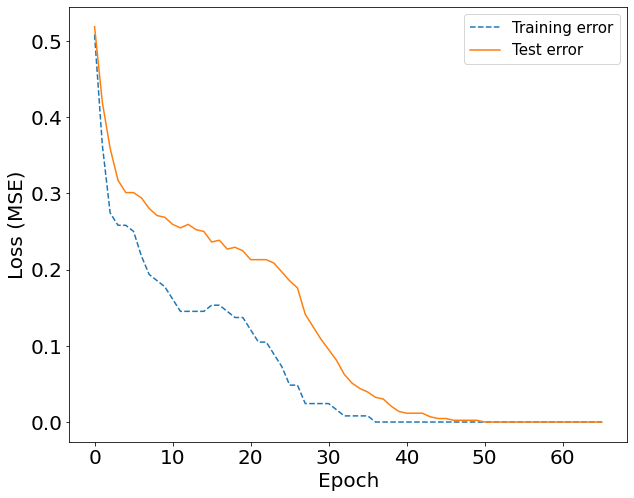

In [ ]:
plot_learning_curves(train_loss_M1, test_loss_M1, classifier_M1.n_iter_, 'Loss (MSE)')

### Learning curves for MONK1

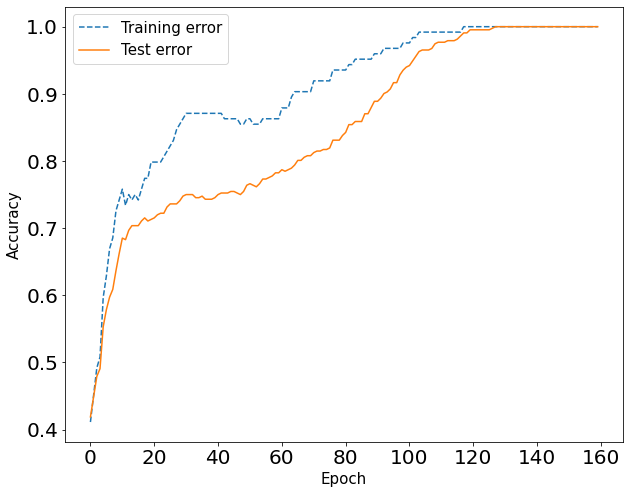

In [ ]:
plot_learning_curves(train_scores_M1, test_scores_M1, classifier_M1.n_iter_, 'Accuracy')

### Accuracy and MEE for MONK1

In [ ]:
y_predicted_train_M1 = classifier_M1.predict(X_train_M1)
y_predicted_M1 = classifier_M1.predict(X_test_M1)
print(f"Accuracy on MONK1 (TRAIN): {classifier_M1.score(X_train_M1, y_train_M1)}")
print(f"Accuracy on MONK1 (TEST): {classifier_M1.score(X_test_M1, y_test_M1)}")
print(f"MSE on MONK1 (TRAIN): {(mean_squared_error(y_train_M1, y_predicted_train_M1))}")
print(f"MSE on MONK1 (TEST): {(mean_squared_error(y_test_M1, y_predicted_M1))}")

Accuracy on MONK1 (TRAIN): 1.0
Accuracy on MONK1 (TEST): 1.0
MSE on MONK1 (TRAIN): 0.0
MSE on MONK1 (TEST): 0.0


### MONK2

### Loading MONK2 dataset

In [ ]:
df_monk2_train, df_monk2_test = load_monk('./data/MONK/monks-2.train', './data/MONK/monks-2.test')

In [ ]:
df_monk2_train.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1


### Splitting MONK2 dataset

In [ ]:
X_train_M2, y_train_M2, X_test_M2, y_test_M2 = split_train_test(df_monk2_train, df_monk2_test)

### One hot encoding on MONK2

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M2)
X_train_M2 = enc_train.transform(X_train_M2).toarray()
print(X_train_M2.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M2)
X_test_M2 = enc_test.transform(X_test_M2).toarray()
print(X_test_M2.shape)

(169, 17)
(432, 17)


### Training phase for MONK2

In [ ]:
classifier_M2 = MLPClassifier(activation='tanh', hidden_layer_sizes=(10,), alpha=0, tol=0.001, learning_rate_init=0.1, batch_size=X_train_M2.shape[0], random_state=RS_NUMBER, solver='sgd', max_iter=1000).fit(X_train_M2, y_train_M2)
eval_model = clone_model(classifier_M2)#unfitted model used for evaluation

In [ ]:
train_scores_M2, test_scores_M2, train_loss_M2, test_loss_M2 = fit_and_score_monk(classifier_M2.n_iter_, eval_model, X_train_M2, y_train_M2, X_test_M2, y_test_M2)

### Loss curve for MONK2

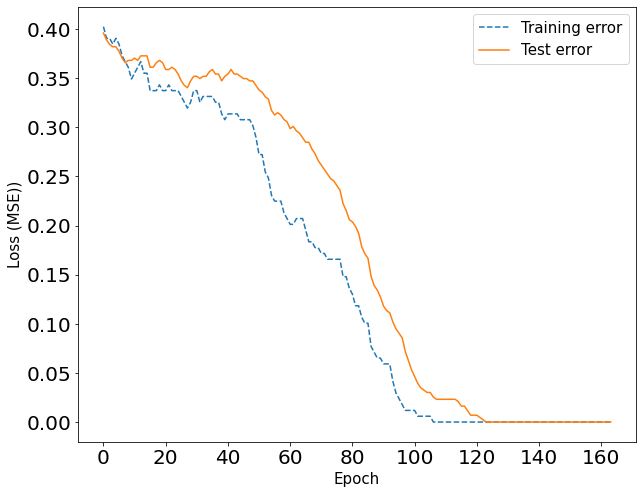

In [ ]:
plot_learning_curves(train_loss_M2, test_loss_M2, classifier_M2.n_iter_, "Loss (MSE))")

### Learning curves for MONK2

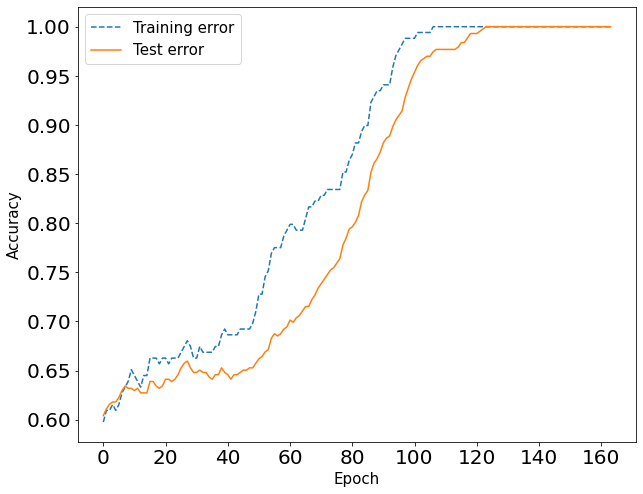

In [ ]:
plot_learning_curves(train_scores_M2, test_scores_M2, classifier_M2.n_iter_, 'Accuracy')

### Accuracy and MEE on MONK2

In [ ]:
y_predicted_train_M2 = classifier_M2.predict(X_train_M2)
y_predicted_M2 = classifier_M2.predict(X_test_M2)
print(f"Accuracy on MONK2 (TRAIN): {classifier_M2.score(X_train_M2, y_train_M2)}")
print(f"Accuracy on MONK2 (TEST): {classifier_M2.score(X_test_M2, y_test_M2)}")
print(f"MSE on MONK2 (TRAIN): {(mean_squared_error(y_train_M2, y_predicted_train_M2))}")
print(f"MSE on MONK2 (TEST): {(mean_squared_error(y_test_M2, y_predicted_M2))}")

Accuracy on MONK2 (TRAIN): 1.0
Accuracy on MONK2 (TEST): 1.0
MSE on MONK2 (TRAIN): 0.0
MSE on MONK2 (TEST): 0.0


### MONK3

### Loading MONK3 dataset

In [ ]:
df_monk3_train, df_monk3_test = load_monk('./data/MONK/monks-3.train', './data/MONK/monks-3.test')

In [ ]:
df_monk3_train.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


### Splitting MONK3 dataset

In [ ]:
X_train_M3, y_train_M3, X_test_M3, y_test_M3 = split_train_test(df_monk3_train, df_monk3_test)

### One hot encoding on MONK3

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M3)
X_train_M3 = enc_train.transform(X_train_M3).toarray()
print(X_train_M3.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M3)
X_test_M3 = enc_test.transform(X_test_M3).toarray()
print(X_test_M3.shape)

(122, 17)
(432, 17)


### Training phase on MONK3

In [ ]:
classifier_M3 = MLPClassifier(activation='tanh', hidden_layer_sizes=(10,), alpha=0.1, tol=0.001, learning_rate_init=0.1, batch_size=X_train_M3.shape[0], random_state=RS_NUMBER, solver='sgd', max_iter=1000).fit(X_train_M3, y_train_M3)
eval_model = clone_model(classifier_M3)#unfitted model used for evaluation

In [ ]:
train_scores_M3, test_scores_M3, train_loss_M3, test_loss_M3 = fit_and_score_monk(classifier_M3.n_iter_, eval_model, X_train_M3, y_train_M3, X_test_M3, y_test_M3)

### Loss curve for MONK3

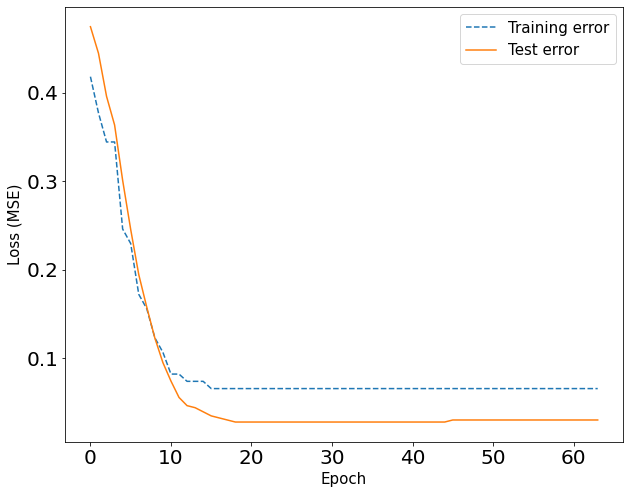

In [ ]:
plot_learning_curves(train_loss_M3, test_loss_M3, classifier_M3.n_iter_, "Loss (MSE)")

### Learning curves for MONK3

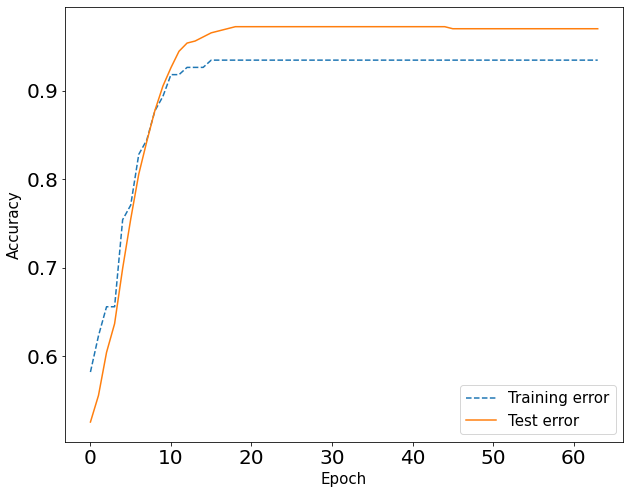

In [ ]:
plot_learning_curves(train_scores_M3, test_scores_M3, classifier_M3.n_iter_, 'Accuracy')
#normal settings tends to overfit, alpha was increased in order to regularize the model 

In [ ]:
y_predicted_train_M3 = classifier_M3.predict(X_train_M3)
y_predicted_M3 = classifier_M3.predict(X_test_M3)
print(f"Accuracy on MONK3 (TRAIN): {classifier_M3.score(X_train_M3, y_train_M3)}")
print(f"Accuracy on MONK3 (TEST): {classifier_M3.score(X_test_M3, y_test_M3)}")
print(f"MSE on MONK3 (TRAIN): {(mean_squared_error(y_train_M3, y_predicted_train_M3))}")
print(f"MSE on MONK3 (TEST): {(mean_squared_error(y_test_M3, y_predicted_M3))}")

Accuracy on MONK3 (TRAIN): 0.9344262295081968
Accuracy on MONK3 (TEST): 0.9699074074074074
MSE on MONK3 (TRAIN): 0.06557377049180328
MSE on MONK3 (TEST): 0.03009259259259259


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>